# Word differences
Up to now, all our prediction are based on the headline itself (and its labels), without looking at the relation to the other headlines in the same test set.
What I'll do now is take all words that occur in given headline, but not in any of the other headlines, as an extra feature (and find a way to embed it).

In [33]:
from util import get_wpm_train_test, get_label_columns

train_x_full, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=False)

features = get_label_columns()  # initially only the manual labels

## Finding the difference
Start by finding the words that are in one of the headlines, but not in any of the other headlines. To make it easier, we'll start with one test.

In [34]:
# Filter train_x_full to get only test 1
current_test = 1
test1 = train_x_full[train_x_full['Test'] == current_test]
test1

,Test,Headline ID,Headline,Actief,Lang,Vragen,Interpunctie,Tweeledigheid,Emotie,Voorwaartse Verwijzing,Signaalwoorden,Lidwoorden,Adjectieven,Eigennamen,Betrekking,Voor+Achternaam,Cijfers,Quotes
0,1,A,Barack en Michelle Obama laten dansmoves zien ...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,B,Barack en Michelle Obama gaan helemaal los tij...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [35]:
test_headlines = test1['Headline'].values
test_headlines

array(['Barack en Michelle Obama laten dansmoves zien tijdens concert Beyoncé en Jay-Z',
       'Barack en Michelle Obama gaan helemaal los tijdens concert'],
      dtype=object)

In [36]:
test_headlines_word_sets = [set(test_headline.split()) for test_headline in test_headlines]

In [37]:
current_headline_id = "A"
# Convert captial letter to position in alphabet
current_headline_idx = ord(current_headline_id) - ord('A')
test_headlines_word_sets[current_headline_idx]

{'Barack',
 'Beyoncé',
 'Jay-Z',
 'Michelle',
 'Obama',
 'concert',
 'dansmoves',
 'en',
 'laten',
 'tijdens',
 'zien'}

In [38]:
import re


def get_word_sets(test_id, df):
    test_headlines = df[df['Test'] == test_id]['Headline'].values
    test_headlines_word_sets = [set(re.sub('[^a-z0-9 ]+', '', test_headline.lower()).split()) for test_headline in
                                test_headlines]
    return test_headlines_word_sets

In [39]:
def word_in_other_headline(word, word_sets, current_headline_idx):
    for i in range(len(word_sets)):
        if i == current_headline_idx:
            continue
        if word in word_sets[i]:
            return True
    return False


print(word_in_other_headline("dansmoves", test_headlines_word_sets, current_headline_idx))
print(word_in_other_headline("concert", test_headlines_word_sets, current_headline_idx))

False
True


In [40]:
def get_word_differences(word_sets, current_headline_idx):
    word_differences = []
    current_headline_set = word_sets[current_headline_idx]
    for word in current_headline_set:
        if not word_in_other_headline(word, word_sets, current_headline_idx):
            word_differences.append(word)
    return word_differences


print(get_word_differences(test_headlines_word_sets, current_headline_idx))
print(get_word_differences(test_headlines_word_sets, 1))

['zien', 'dansmoves', 'Beyoncé', 'laten', 'Jay-Z']
['helemaal', 'los', 'gaan']


In [41]:
def add_difference_strings(df):
    new_df = df.copy()

    current_test = -1
    current_word_set = {}

    new_df.reset_index(drop=True, inplace=True)

    new_df['Word Differences'] = ""

    for i in range(len(new_df)):
        headline_letter = new_df.loc[i, 'Headline ID'][0]
        headline_idx = ord(headline_letter) - ord('A')

        test_id = new_df.loc[i, 'Test']

        if test_id != current_test:
            current_test = test_id
            current_word_set = get_word_sets(test_id, df)

        word_differences = get_word_differences(current_word_set, headline_idx)
        new_df.loc[i, 'Word Differences'] = " ".join(word_differences)

    return new_df


train_x_extended = add_difference_strings(train_x_full)
train_x_extended[['Headline', 'Test', 'Word Differences']].head(n=6)

,Headline,Test,Word Differences
0,Barack en Michelle Obama laten dansmoves zien ...,1,beyonc zien dansmoves jayz laten
1,Barack en Michelle Obama gaan helemaal los tij...,1,helemaal gaan los
2,Marc Coucke maakt opvallende keuze bij start v...,2,bij seizoen maakt opvallende keuze start
3,"Marc Coucke: ""Spelers van 10 miljoen? Neen, li...",2,eigen liever spelers miljoen jeugd neen 10
4,Maandag drukste dag van het jaar op Brussels A...,3,zorg en zeker bent dat goed kom voorbereid tijd
5,Maandag drukste dag van het jaar op Brussels A...,3,reizigers bijna verwacht 100000


## Using the word differences
Now we have the different words, we can use features based on this.

### Diff length
The numbr of words in the difference or the average word length might be useful extra features.


In [42]:
features.append('NumWordsDiff')
features.append('AvgWordLengthDiff')


def count_words(word_differences):
    return len(word_differences.split())


def get_avg_word_length(word_differences):
    words_count = count_words(word_differences)
    return len(word_differences) / words_count if words_count > 0 else 0


def get_max_word_length(word_differences):
    words = word_differences.split()
    return max([len(word) for word in words]) if words else 0


def add_diff_length(df):
    new_df = df.copy()
    new_df["NumWordsDiff"] = df["Word Differences"].apply(count_words)
    new_df["AvgWordLengthDiff"] = df["Word Differences"].apply(get_avg_word_length)
    new_df["MaxWordLengthDiff"] = df["Word Differences"].apply(get_max_word_length)
    return new_df


train_x_extended = add_diff_length(train_x_extended)
train_x_extended[
    ['Headline', 'Test', 'Word Differences', 'NumWordsDiff', 'AvgWordLengthDiff', 'MaxWordLengthDiff']].head(n=6)

,Headline,Test,Word Differences,NumWordsDiff,AvgWordLengthDiff,MaxWordLengthDiff
0,Barack en Michelle Obama laten dansmoves zien ...,1,beyonc zien dansmoves jayz laten,5,6.400000,9
1,Barack en Michelle Obama gaan helemaal los tij...,1,helemaal gaan los,3,5.666667,8
2,Marc Coucke maakt opvallende keuze bij start v...,2,bij seizoen maakt opvallende keuze start,6,6.666667,10
3,"Marc Coucke: ""Spelers van 10 miljoen? Neen, li...",2,eigen liever spelers miljoen jeugd neen 10,7,6.000000,7
4,Maandag drukste dag van het jaar op Brussels A...,3,zorg en zeker bent dat goed kom voorbereid tijd,9,5.222222,10
5,Maandag drukste dag van het jaar op Brussels A...,3,reizigers bijna verwacht 100000,4,7.750000,9


#### Evaluate

In [43]:
from util import get_naive_bayes_model_wp, print_wp_evaluation, predict_wp, get_xgboost_model_wp


def fit_predict_evaluate_extra_features(train_x_new, train_y, test_x_new, test_y, feature_columns, train_groups):
    model_nb = get_naive_bayes_model_wp()

    model_nb.fit(train_x_new[features], train_y["Winner"])
    predicted_winners = predict_wp(model_nb, test_x_new, features=feature_columns)
    print_wp_evaluation(predicted_winners, test_y)

    model_xgb = get_xgboost_model_wp()

    model_xgb.fit(train_x_new[features], train_y["Winner"], train_groups)
    predicted_winners = predict_wp(model_xgb, test_x_new, features=feature_columns)
    print_wp_evaluation(predicted_winners, test_y)
    return model_nb, model_xgb

In [44]:
test_x_extended = add_diff_length(add_difference_strings(test_x))
_, model_xgb = fit_predict_evaluate_extra_features(train_x_extended, train_y, test_x_extended, test_y, features, groups)

Accuracy: 57.14% (104/182)


C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Accuracy: 53.30% (97/182)


This gives the same result as the baseline for Naive Bayes and for xgboost a slight increase (of the same size as the baseline).


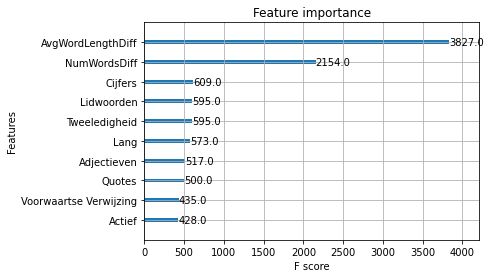

<Figure size 1152x864 with 0 Axes>

In [45]:
from util import get_xgboost_importance

get_xgboost_importance(model_xgb)

### Sentence Embeddings
We can also try to find embeddings for the words in the difference.

In [46]:
from util import add_headline_embedding_to_dataframe

features = get_label_columns()

train_x_extended = add_difference_strings(train_x_full)
train_x_extended, new_features = add_headline_embedding_to_dataframe(train_x_extended, emb_prefix="DiffEmb",
                                                                     text_column="Word Differences")
features += new_features

train_x_extended[['Headline', 'Test', 'Word Differences', 'DiffEmb0', 'DiffEmb1']].head(n=6)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,Headline,Test,Word Differences,DiffEmb0,DiffEmb1
0,Barack en Michelle Obama laten dansmoves zien ...,1,beyonc zien dansmoves jayz laten,0.003917,-0.067513
1,Barack en Michelle Obama gaan helemaal los tij...,1,helemaal gaan los,0.115524,-0.751650
2,Marc Coucke maakt opvallende keuze bij start v...,2,bij seizoen maakt opvallende keuze start,0.273491,-0.293598
3,"Marc Coucke: ""Spelers van 10 miljoen? Neen, li...",2,eigen liever spelers miljoen jeugd neen 10,-0.306837,0.778798
4,Maandag drukste dag van het jaar op Brussels A...,3,zorg en zeker bent dat goed kom voorbereid tijd,-0.854726,-0.240404
5,Maandag drukste dag van het jaar op Brussels A...,3,reizigers bijna verwacht 100000,0.265976,0.045437


In [47]:
test_x_extended = add_difference_strings(test_x)
test_x_extended, _ = add_headline_embedding_to_dataframe(test_x_extended, emb_prefix="DiffEmb",
                                                         text_column="Word Differences")

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [48]:
_, model_xgb = fit_predict_evaluate_extra_features(train_x_extended, train_y, test_x_extended, test_y, features, groups)

Accuracy: 50.55% (92/182)


C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Accuracy: 47.80% (87/182)


This leads to quite a high decrease (-12%) for naive bayes, but an increase (+2.75%) for xgboost.

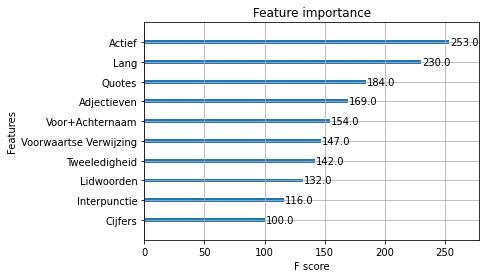

<Figure size 1152x864 with 0 Axes>

In [49]:
get_xgboost_importance(model_xgb)

### Word Embeddings
Since our difference is just a collection of words instead of a sentence, we can try encoding each word separately and then use a form of pooling to get one vector for all words.

In [50]:
from sentence_transformers import util, SentenceTransformer

model = SentenceTransformer('jegormeister/bert-base-dutch-cased-snli')

model.encode("Appel")[:5]

array([-0.3001115 , -1.2974211 , -1.8229753 ,  1.3705543 , -0.05285694],
      dtype=float32)

In [51]:
words = ["Tomaat", "Paprika", "Fruit", "Mes", "Tafel", "Stoel", "Auto", "Garage", "Hond", "Wolf", "Appel"]

#Encode all words
embeddings = list([model.encode(word) for word in words])

#Compute cosine similarity between all pairs
cos_sim = util.cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_word_combinations = []
for i in range(len(cos_sim) - 1):
    for j in range(i + 1, len(cos_sim)):
        all_word_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_word_combinations = sorted(all_word_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_word_combinations[0:5]:
    print("{} \t {} \t {:.4f}".format(words[i], words[j], cos_sim[i][j]))

Top-5 most similar pairs:
Fruit 	 Appel 	 0.6018
Hond 	 Wolf 	 0.5938
Mes 	 Tafel 	 0.5386
Tafel 	 Garage 	 0.5356
Tomaat 	 Paprika 	 0.5041


In [74]:
import numpy as np
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

def get_word_vector(words, model, pooling="avg"):
    words = words.split()

    if not words:
        return np.zeros(768)

    embeddings = list([model.encode(word) for word in words])

    # Some pooling methods suggested by copilot
    if pooling == "avg":
        return np.mean(embeddings, axis=0)
    elif pooling == "max":
        return np.max(embeddings, axis=0)
    elif pooling == "min":
        return np.min(embeddings, axis=0)
    elif pooling == "sum":
        return np.sum(embeddings, axis=0)
    # elif pooling == "concat": # Will end up in variable number of features, so skip this one
    #     return np.concatenate(embeddings, axis=0)
    else:
        raise ValueError("Pooling method not supported")


def add_pooled_word_embeddings_to_dataframe(df, emb_prefix="DiffEmb", text_column="Word Differences", pooling="avg"):
    bertje = SentenceTransformer("jegormeister/bert-base-dutch-cased-snli")

    embedding_columns = list(map(lambda i: f"{emb_prefix}{i}", range(768)))
    added_features = embedding_columns

    modified_df = df.copy()
    tmp = df[text_column].progress_apply(lambda x: get_word_vector(x, bertje, pooling)).apply(pd.Series)
    modified_df[embedding_columns] = tmp #df[text_column].progress_apply(lambda x: get_word_vector(x, bertje, pooling))
    return modified_df, added_features

In [75]:
from util import get_label_columns

features = get_label_columns()

train_x_extended = add_difference_strings(train_x_full)
train_x_extended, new_features = add_pooled_word_embeddings_to_dataframe(train_x_extended)

features += new_features

test_x_extended = add_difference_strings(test_x)
test_x_extended, _ = add_pooled_word_embeddings_to_dataframe(test_x_extended)

100%|██████████| 1804/1804 [04:43<00:00,  6.36it/s]
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]
100%|██████████| 453/453 [01:08<00:00,  6.61it/s]


In [76]:
_, model_xgb = fit_predict_evaluate_extra_features(train_x_extended, train_y, test_x_extended, test_y, features, groups)

Accuracy: 49.45% (90/182)


C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Accuracy: 51.10% (93/182)


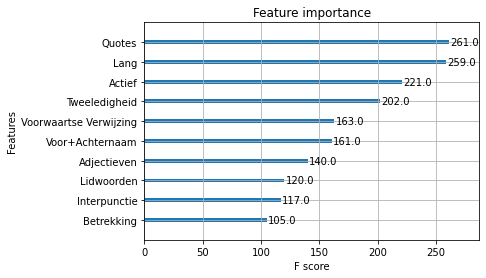

<Figure size 1152x864 with 0 Axes>

In [77]:
get_xgboost_importance(model_xgb)